# Passion fruit modeling
Author: Teslim Olayiwola

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') # Competitions/Passionfruit

Mounted at /content/drive/


## Setup

Extract and Import

In [ ]:
!pip install torchinfo

## Import libraries

In [ ]:
import os
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, models, transforms

# Important! Don't change this
torch.backends.cudnn.deterministic = True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'

print(f"Using {device} device.")

Using cuda device.


In [ ]:
full_images_path = "/content/drive/MyDrive/Competitions/Passionfruit"

## Extract files from the Image folder

In [ ]:
# Extracting the files
!unzip '/content/drive/MyDrive/Competitions/Passionfruit/Images.zip' -d Images

Archive:  /content/drive/MyDrive/Competitions/Passionfruit/Images.zip
  inflating: Images/ImageID_0AEWIFSR.jpg  
  inflating: Images/ImageID_0AJHZJC8.jpg  
  inflating: Images/ImageID_0AQ2CF5Z.jpg  
  inflating: Images/ImageID_0BCOVSUP.jpg  
  inflating: Images/ImageID_0BG0ML6J.jpg  
  inflating: Images/ImageID_0BU90GSO.jpg  
  inflating: Images/ImageID_0CM6V15J.jpg  
  inflating: Images/ImageID_0D05VND4.jpg  
  inflating: Images/ImageID_0DV16WLW.jpg  
  inflating: Images/ImageID_0DX6F505.jpg  
  inflating: Images/ImageID_0EEJWTUW.jpg  
  inflating: Images/ImageID_0ESCEW0D.jpg  
  inflating: Images/ImageID_0GWZPGVK.jpg  
  inflating: Images/ImageID_0HBUT8NL.jpg  
  inflating: Images/ImageID_0I85S3XE.jpg  
  inflating: Images/ImageID_0IXPF9NN.jpg  
  inflating: Images/ImageID_0KM0L4CR.jpg  
  inflating: Images/ImageID_0KSXNX66.jpg  
  inflating: Images/ImageID_0LM2N74U.jpg  
  inflating: Images/ImageID_0LM34FVD.jpg  
  inflating: Images/ImageID_0LNHX1B9.jpg  
  inflating: Images/ImageID

## Load data
load data from csv into dataframe

In [ ]:
train = pd.read_csv(f'{full_images_path}/Train.csv')
print(train.shape)
train.head(2)

(1548, 2)


,Image_ids,class
0,ImageID_ZWY4MO08,fruit_healthy
1,ImageID_OZQDOU6U,fruit_brownspot


In [ ]:
test = pd.read_csv(f'{full_images_path}/Test.csv')
print(test.shape)
test.head(2)

(516, 1)


,Image_ids
0,ImageID_GXD1UROG
1,ImageID_U9W52JFZ


## Data Validation
Count the number of images in dataframe not found in the Images folder

In [ ]:
import os

def number_missing_mages(df):
  not_found_count = 0
  for image in df["Image_ids"]:
      if not os.path.exists(f'Images/{image}.jpg'):
          print(f'Image {image} not found')
          not_found_count += 1
  return not_found_count


print(f'Number of train images not found: {number_missing_mages(train)}')
print(f'Number of test images not found: {number_missing_mages(test)}')

Number of train images not found: 0
Number of test images not found: 0


## Visualize the available data

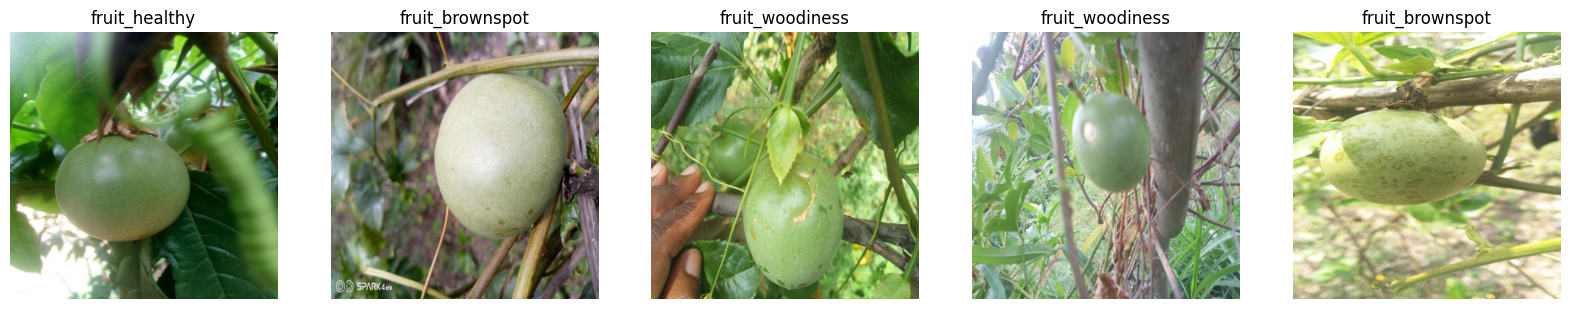

In [ ]:
# view images
import PIL
import random
import numpy as np
def sample_images(df, label=False, seed=42):
    random.seed(seed)

    # Pick four random images
    images = df["Image_ids"].tolist()
    if label is True:
      classes = df["class"].tolist()
    indices = list(np.arange(0, len(images)))
    random_selection = random.sample(indices, 5)

    # Plot them
    plt.figure(figsize=(20, 20))
    for idx, pos in enumerate(random_selection):
      path = f"Images/{images[pos]}.jpg"
      img = PIL.Image.open(path)
      plt.subplot(1, 5, idx + 1)
      plt.imshow(img)
      if label:
        plt.title(classes[pos])
      plt.axis("off")

sample_images(train, label=True, seed=16)

In [ ]:
# check the numbers of classes
print(f"Number of classes: {train['class'].nunique()}")
print(f"Class include: {train['class'].unique()}")

Number of classes: 3
Class include: ['fruit_healthy' 'fruit_brownspot' 'fruit_woodiness']


## Count the number of classes in train and do a bar plot

<Axes: xlabel='class'>

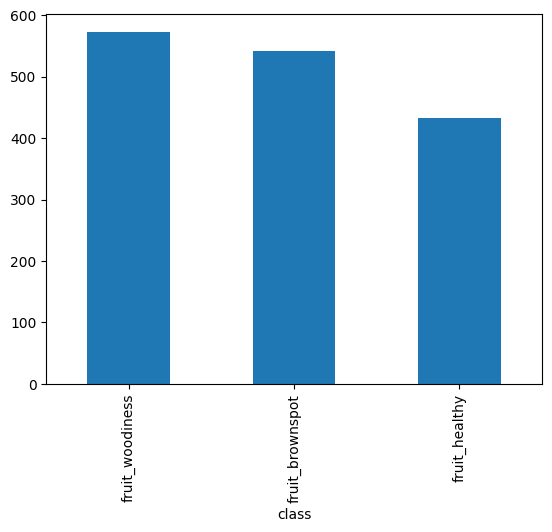

In [ ]:
# count the number of classes in train and do a bar plot
train["class"].value_counts().plot(kind='bar')

*Each class are well represented.*

## move images into subfolders

In [ ]:
from tqdm import tqdm
def create_folder(train, test, image_id="Image_ids", label_id="class"):
    """
    1. create a folder called train and test
    2. in the train folder, create subfolders for the unique classes
    3. move the images in the train folder to the respective class subfolders

    """
    # 1. create the train and test folders
    if not os.path.exists("data/train"):
        os.makedirs("data/train")
    if not os.path.exists("data/test"):
        os.makedirs("data/test")
    # 2. create subfolders for the unique classes
    # use tqdm for progress bar

    for i in tqdm(train[label_id].unique(), desc="make subfolders for unique classes in train"):
        if not os.path.exists(f"data/train/{i}"):
            os.makedirs(f"data/train/{i}")

    # 3. move the images in the train folder to the respective class subfolders
    for i in tqdm(train[image_id], desc="move images in train folder into subfolders"):
        os.rename(f"Images/{i}.jpg", f"data/train/{train[train[image_id] == i][label_id].values[0]}/{i}.jpg")

    # 4. move the images in the test folder to the test folder
    for i in tqdm(test[image_id], desc="move test images to test folder"):
        os.rename(f"Images/{i}.jpg", f"data/test/{i}.jpg")

    print("Successfully created the folders")

create_folder(train, test)

move test images to test folder: 100%|██████████| 516/516 [00:00<00:00, 49324.51it/s]

Successfully created the folders


In [ ]:
train_dir = "data/train"

print("Training Data Directory:", train_dir)

Training Data Directory: data/train


In [ ]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['fruit_brownspot', 'fruit_healthy', 'fruit_woodiness']


Herein, the following transformations are applied:

- Convert any grayscale images to RGB format with a custom class
- Resize the image, so that they're all the same size (we chose $224$ x $224$)
- Convert the image to a Tensor of pixel values
- Normalize the data (we normalize each color channel separately)

Transform images to RGB format and resize to compute mean and std

In [ ]:
height = 224
width = 224

class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ]
)

In [ ]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size=batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: tensor([0.4827, 0.5401, 0.3589])
Standard deviation: tensor([0.2356, 0.2213, 0.2435])


In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [ ]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size=batch_size)

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


confirm if the normalization is complete

In [ ]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Mean: tensor([-3.2235e-08,  1.0887e-07, -3.6949e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


## Data preparation

### Train-Validation Split

In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [80/100, 20/100], generator=g)

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.04% of full data
Validation data is 19.96% of full data


In [ ]:
from collections import Counter

def class_counts(dataset):
    "credit: WorldQuants University"
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


100%|██████████| 1548/1548 [00:08<00:00, 179.42it/s]


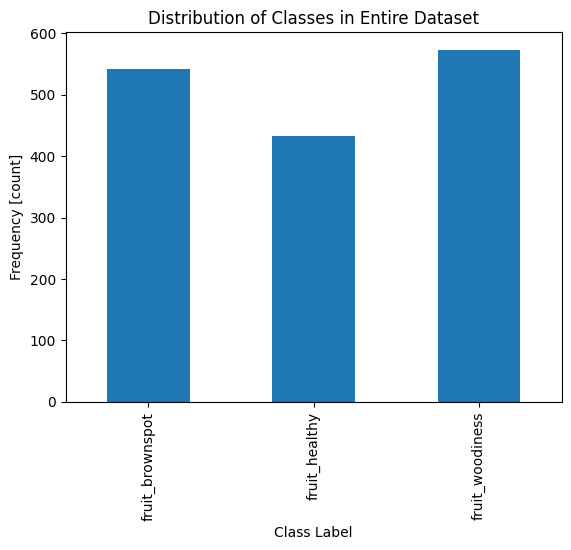

In [ ]:
# all dataset
dataset_counts = class_counts(dataset)
# Make a bar chart from the function output
dataset_counts.plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Entire Dataset");

100%|██████████| 1239/1239 [00:06<00:00, 190.13it/s]


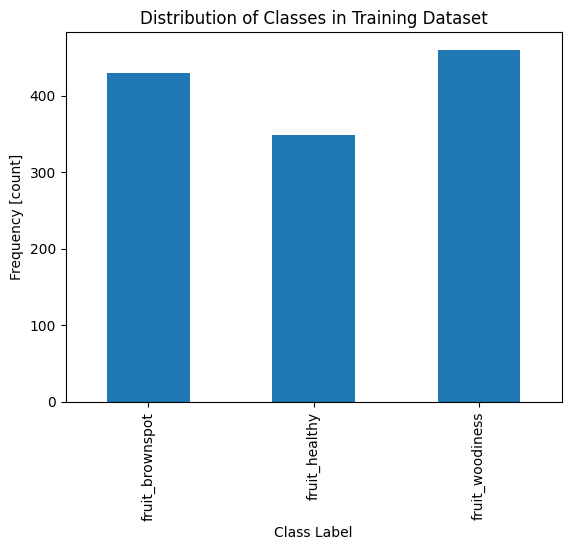

In [ ]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.plot(kind='bar')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

100%|██████████| 309/309 [00:01<00:00, 200.84it/s]


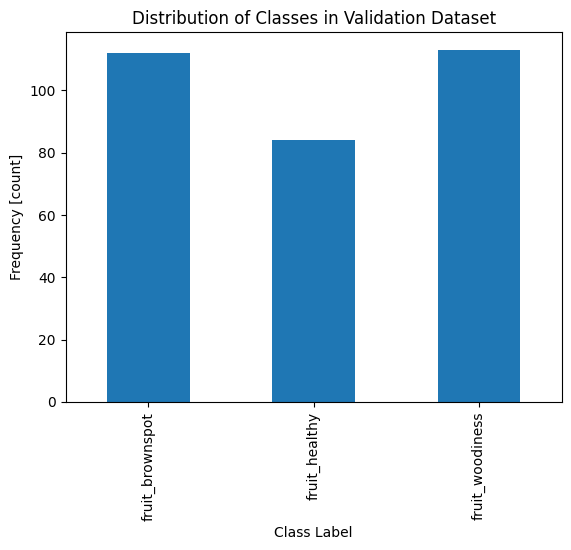

In [ ]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.plot(kind='bar')
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

In [ ]:
# Create a DataLoader for the training and validation sets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, generator=g)

<class 'torch.utils.data.dataloader.DataLoader'>


### Model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1_n_kernels = 16
conv1 = torch.nn.Conv2d(
    in_channels=3, out_channels=conv1_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool_size = 4
max_pool1 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2_n_kernels = 32
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=conv2_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool2 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3_n_kernels = 64
conv3 = torch.nn.Conv2d(32, conv3_n_kernels, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=576, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

n_classes = len(classes)
output_layer = torch.nn.Linear(500, n_classes)
model.append(output_layer)

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─

In [ ]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Make sure to send the model to the GPU
model.to(device)
print(loss_fn)
print("----------------------")
print(optimizer)
print("----------------------")
print(next(model.parameters()).device)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
----------------------
cuda:0


### Training the model

In [ ]:
# These python functions were originally created by WorldQuant University and then modified by me

# train_epoch function
def train_epoch(model, optimizer, loss_fn, data_loader, device="gpu"):
    '''Trains the model for one epoch.
    Input:
        model: the neural network model
        optimizer: the optimizer object
        loss_fn: the loss function
        data_loader: DataLoader object containing the training data
        device: device to run the model on
    Output:
        training_loss: the average loss over the training data for the epoch'''
    training_loss = 0.0 # Initialize the training loss to 0
    model.train() # Set the model to training mode

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

# predict function
def predict(model, data_loader, device="cpu"):
    '''Predicts the probabilities of each class for each observation in the data_loader.
    Input: 
        model: trained model
        data_loader: DataLoader object containing the data to predict
        device: device to run the model on
    Output: 
        all_probs: probabilities of each class for each observation in the data_loader'''
    
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

# score function
def score(model, data_loader, loss_fn, device="cpu"):
    '''Scores the model on the data in data_loader.
    Input:
        model: trained model
        data_loader: DataLoader object containing the data to score
        loss_fn: loss function
        device: device to run the model on
    Output:
        average_loss: the average loss over the data
        accuracy: the accuracy of the model on the data'''
    
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    n_observations = data_loader.batch_size * len(data_loader)
    average_loss = total_loss / n_observations
    accuracy = total_correct / n_observations
    return average_loss, accuracy

# train function
def implement(
    model, optimizer, loss_fn,
    train_loader, val_loader,
    epochs=20, device="cpu"):
    '''Trains the model on the training data and evaluates it on the validation data.
    Input:
        model: the neural network model
        optimizer: the optimizer object
        loss_fn: the loss function
        train_loader: DataLoader object containing the training data
        val_loader: DataLoader object containing the validation data
        epochs: number of epochs to train the model
        device: device to run the model on
        use_train_accuracy: whether to calculate training accuracy
    Output:
        train_losses: list of training losses for each epoch
        val_losses: list of validation losses for each epoch
        train_accuracies: list of training accuracies for each epoch
        val_accuracies: list of validation accuracies for each epoch'''
    
    # Track the model progress over epochs
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Evaluate training results
        train_loss, train_accuracy = score(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)
        val_losses.append(validation_loss)
        val_accuracies.append(validation_accuracy)

        print(f"Epoch: {epoch}")
        print(f"    Training loss: {train_loss:.2f}")
        print(f"    Training accuracy: {train_accuracy:.2f}")
        print(f"    Validation loss: {validation_loss:.2f}")
        print(f"    Validation accuracy: {validation_accuracy:.2f}")

    return train_losses, val_losses, train_accuracies, val_accuracies




In [ ]:
# Train the model
epochs = 30

train_losses, val_losses, train_accuracies, val_accuracies = implement(
    model, optimizer, loss_fn, train_loader, val_loader, epochs, device=device
)

Epoch: 1
    Training loss: 0.75
    Training accuracy: 0.66
    Validation loss: 0.77
    Validation accuracy: 0.63


Epoch: 2
    Training loss: 0.58
    Training accuracy: 0.76
    Validation loss: 0.62
    Validation accuracy: 0.73


Epoch: 3
    Training loss: 0.58
    Training accuracy: 0.75
    Validation loss: 0.60
    Validation accuracy: 0.72


Epoch: 4
    Training loss: 0.40
    Training accuracy: 0.85
    Validation loss: 0.43
    Validation accuracy: 0.80


Epoch: 5
    Training loss: 0.39
    Training accuracy: 0.83
    Validation loss: 0.42
    Validation accuracy: 0.81


Epoch: 6
    Training loss: 0.30
    Training accuracy: 0.90
    Validation loss: 0.35
    Validation accuracy: 0.84


Epoch: 7
    Training loss: 0.31
    Training accuracy: 0.88
    Validation loss: 0.36
    Validation accuracy: 0.82


Epoch: 8
    Training loss: 0.30
    Training accuracy: 0.87
    Validation loss: 0.35
    Validation accuracy: 0.84


Epoch: 9
    Training loss: 0.22
    Training accuracy: 0.91
    Validation loss: 0.29
    Validation accuracy: 0.88


Epoch: 10
    Training loss: 0.22
    Training accuracy: 0.91
    Validation loss: 0.29
    Validation accuracy: 0.88


Epoch: 11
    Training loss: 0.21
    Training accuracy: 0.92
    Validation loss: 0.29
    Validation accuracy: 0.87


Epoch: 12
    Training loss: 0.17
    Training accuracy: 0.94
    Validation loss: 0.26
    Validation accuracy: 0.88


Epoch: 13
    Training loss: 0.14
    Training accuracy: 0.95
    Validation loss: 0.24
    Validation accuracy: 0.89


Epoch: 14
    Training loss: 0.13
    Training accuracy: 0.95
    Validation loss: 0.25
    Validation accuracy: 0.88


Epoch: 15
    Training loss: 0.20
    Training accuracy: 0.92
    Validation loss: 0.35
    Validation accuracy: 0.82


Epoch: 16
    Training loss: 0.13
    Training accuracy: 0.95
    Validation loss: 0.29
    Validation accuracy: 0.87


Epoch: 17
    Training loss: 0.10
    Training accuracy: 0.96
    Validation loss: 0.23
    Validation accuracy: 0.89


Epoch: 18
    Training loss: 0.07
    Training accuracy: 0.97
    Validation loss: 0.21
    Validation accuracy: 0.87


Epoch: 19
    Training loss: 0.10
    Training accuracy: 0.96
    Validation loss: 0.27
    Validation accuracy: 0.86


Epoch: 20
    Training loss: 0.09
    Training accuracy: 0.96
    Validation loss: 0.25
    Validation accuracy: 0.88


Epoch: 21
    Training loss: 0.06
    Training accuracy: 0.98
    Validation loss: 0.19
    Validation accuracy: 0.89


Epoch: 22
    Training loss: 0.07
    Training accuracy: 0.97
    Validation loss: 0.25
    Validation accuracy: 0.87


Epoch: 23
    Training loss: 0.05
    Training accuracy: 0.97
    Validation loss: 0.21
    Validation accuracy: 0.89


Epoch: 24
    Training loss: 0.07
    Training accuracy: 0.97
    Validation loss: 0.27
    Validation accuracy: 0.87


Epoch: 25
    Training loss: 0.15
    Training accuracy: 0.94
    Validation loss: 0.40
    Validation accuracy: 0.83


Epoch: 26
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.15
    Validation accuracy: 0.91


Epoch: 27
    Training loss: 0.07
    Training accuracy: 0.96
    Validation loss: 0.23
    Validation accuracy: 0.88


Epoch: 28
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.17
    Validation accuracy: 0.90


Epoch: 29
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.19
    Validation accuracy: 0.89


Epoch: 30
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.16
    Validation accuracy: 0.91


Plot the learning curve

Text(0, 0.5, 'Accuracy')

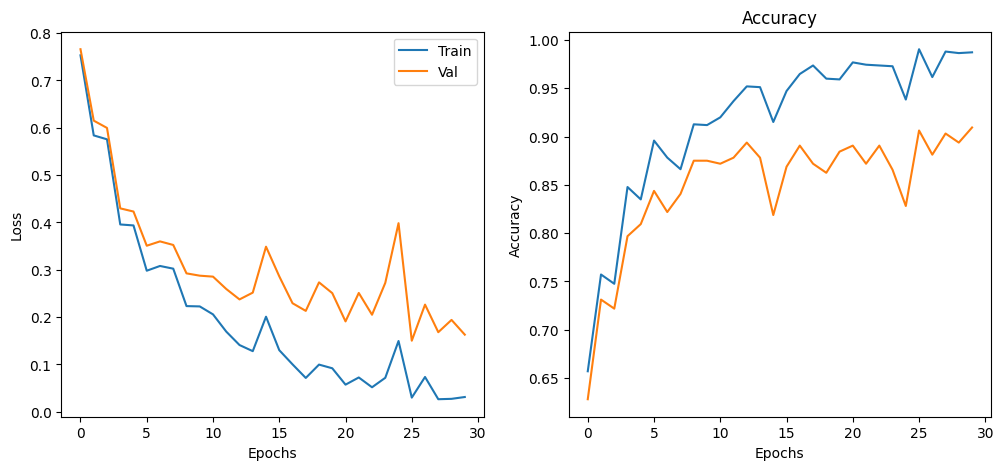

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_losses, label="Train")
axs[0].plot(val_losses, label="Val")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_accuracies, label="Train")
axs[1].plot(val_accuracies, label="Val")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

### Check accuracy on validation data
plot confusion matrix

In [ ]:
probabilities_val = predict(model, val_loader, device)
predictions_val = torch.argmax(probabilities_val, dim=1)

print(predictions_val)

tensor([2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 2, 1, 0, 2, 0, 2, 0, 0,
        2, 0, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0, 2, 1,
        0, 2, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 0, 2, 2, 2,
        1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1,
        0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0,
        1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0,
        1, 0, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 1, 2,
        2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0,
        2, 2, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 2,
        0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 1, 2, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0,
        0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1, 0, 0,
        2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2,

In [ ]:
targets_val = torch.cat(
    [labels for _, labels in tqdm(val_loader, desc="Get Labels")]
).to(device)

Get Labels: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


<Figure size 1000x800 with 0 Axes>

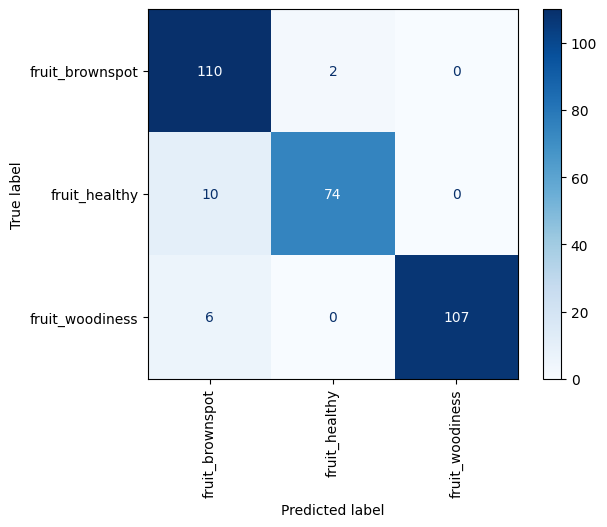

In [ ]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Set figure size
plt.figure(figsize=(10, 8))

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

### Apply model on test data

In [ ]:
test['file_path'] = test['Image_ids'].apply(lambda x: f'data/test/{x}.jpg')
test.head(5)

,Image_ids,file_path,predictions
0,ImageID_GXD1UROG,data/test/ImageID_GXD1UROG.jpg,fruit_woodiness
1,ImageID_U9W52JFZ,data/test/ImageID_U9W52JFZ.jpg,fruit_brownspot
2,ImageID_18ZU2YP5,data/test/ImageID_18ZU2YP5.jpg,fruit_woodiness
3,ImageID_8RBI9ZMH,data/test/ImageID_8RBI9ZMH.jpg,fruit_brownspot
4,ImageID_ZYJELERW,data/test/ImageID_ZYJELERW.jpg,fruit_woodiness


In [ ]:
model.to(device)

def file_to_df(file_path):
    image = PIL.Image.open(file_path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    index_predictions = torch.argmax(confidence)
    predictions = dataset.classes[index_predictions]

    return predictions

In [ ]:
def create_submission(df, id=0):
  data = df.copy()
  data['class'] = data['file_path'].apply(file_to_df)
  data[['Image_ids', 'class']].to_csv(f'teslim_submission_{id}.csv', index=False)
  print('Files written')
  return data

In [ ]:
submit = create_submission(test, id=0)
submit.head(10)

Files written


,Image_ids,file_path,predictions,class
0,ImageID_GXD1UROG,data/test/ImageID_GXD1UROG.jpg,fruit_woodiness,fruit_woodiness
1,ImageID_U9W52JFZ,data/test/ImageID_U9W52JFZ.jpg,fruit_brownspot,fruit_brownspot
2,ImageID_18ZU2YP5,data/test/ImageID_18ZU2YP5.jpg,fruit_woodiness,fruit_woodiness
3,ImageID_8RBI9ZMH,data/test/ImageID_8RBI9ZMH.jpg,fruit_brownspot,fruit_brownspot
4,ImageID_ZYJELERW,data/test/ImageID_ZYJELERW.jpg,fruit_woodiness,fruit_woodiness
5,ImageID_UFP8XR2T,data/test/ImageID_UFP8XR2T.jpg,fruit_woodiness,fruit_woodiness
6,ImageID_CE68LAH8,data/test/ImageID_CE68LAH8.jpg,fruit_brownspot,fruit_brownspot
7,ImageID_VTJN2V5N,data/test/ImageID_VTJN2V5N.jpg,fruit_healthy,fruit_healthy
8,ImageID_2OFZMNS4,data/test/ImageID_2OFZMNS4.jpg,fruit_brownspot,fruit_brownspot
9,ImageID_1AA21YGY,data/test/ImageID_1AA21YGY.jpg,fruit_brownspot,fruit_brownspot


# Transfer learning with resnet

### Retrieve resnet model

In [ ]:
import torchvision

resnet_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze the pretrained weights
for params in resnet_model.parameters():
    params.requires_grad = False
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### append new layers to pretrained model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get last layer in resnet
last_layer = list(resnet_model.named_modules())[-1]
# get the last input features (from the resnet model)
in_features = last_layer[1].in_features
print(in_features)
# create the new final classifier
modified_last_layer = nn.Sequential()

dense_layer = nn.Linear(in_features, 256)
modified_last_layer.append(dense_layer)

relu = torch.nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

output_layer = nn.Linear(256, len(classes))
modified_last_layer.append(output_layer)

# Assign `modified_last_layer` to `model.fc`
resnet_model.fc = modified_last_layer

print(resnet_model)

2048
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

### train pretrained model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Place the model on device
resnet_model.to(device)
# Train the model for 15 epochs
epochs = 15
resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies = train(
    resnet_model, resnet_optimizer, loss_fn, train_loader, val_loader, epochs, device=device
)

Epoch: 1
    Training loss: 0.42
    Training accuracy: 0.89
    Validation loss: 0.48
    Validation accuracy: 0.83


Epoch: 2
    Training loss: 0.25
    Training accuracy: 0.93
    Validation loss: 0.35
    Validation accuracy: 0.85


Epoch: 3
    Training loss: 0.16
    Training accuracy: 0.96
    Validation loss: 0.30
    Validation accuracy: 0.86


Epoch: 4
    Training loss: 0.11
    Training accuracy: 0.97
    Validation loss: 0.26
    Validation accuracy: 0.87


Epoch: 5
    Training loss: 0.09
    Training accuracy: 0.97
    Validation loss: 0.26
    Validation accuracy: 0.87


Epoch: 6
    Training loss: 0.09
    Training accuracy: 0.97
    Validation loss: 0.27
    Validation accuracy: 0.87


Epoch: 7
    Training loss: 0.07
    Training accuracy: 0.98
    Validation loss: 0.28
    Validation accuracy: 0.87


Epoch: 8
    Training loss: 0.06
    Training accuracy: 0.98
    Validation loss: 0.30
    Validation accuracy: 0.87


Epoch: 9
    Training loss: 0.07
    Training accuracy: 0.96
    Validation loss: 0.36
    Validation accuracy: 0.86


Epoch: 10
    Training loss: 0.04
    Training accuracy: 0.98
    Validation loss: 0.32
    Validation accuracy: 0.87


Epoch: 11
    Training loss: 0.04
    Training accuracy: 0.99
    Validation loss: 0.25
    Validation accuracy: 0.88


Epoch: 12
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.28
    Validation accuracy: 0.88


Epoch: 13
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.26
    Validation accuracy: 0.87


Epoch: 14
    Training loss: 0.03
    Training accuracy: 0.99
    Validation loss: 0.27
    Validation accuracy: 0.87


Epoch: 15
    Training loss: 0.02
    Training accuracy: 0.99
    Validation loss: 0.31
    Validation accuracy: 0.87


### apply to test data

In [ ]:
test.head()

,Image_ids,file_path,predictions
0,ImageID_GXD1UROG,data/test/ImageID_GXD1UROG.jpg,fruit_woodiness
1,ImageID_U9W52JFZ,data/test/ImageID_U9W52JFZ.jpg,fruit_brownspot
2,ImageID_18ZU2YP5,data/test/ImageID_18ZU2YP5.jpg,fruit_woodiness
3,ImageID_8RBI9ZMH,data/test/ImageID_8RBI9ZMH.jpg,fruit_brownspot
4,ImageID_ZYJELERW,data/test/ImageID_ZYJELERW.jpg,fruit_woodiness


In [ ]:
submit = create_submission(test, id='resnet0')
submit.head(10)

Files written


,Image_ids,file_path,predictions,class
0,ImageID_GXD1UROG,data/test/ImageID_GXD1UROG.jpg,fruit_woodiness,fruit_woodiness
1,ImageID_U9W52JFZ,data/test/ImageID_U9W52JFZ.jpg,fruit_brownspot,fruit_brownspot
2,ImageID_18ZU2YP5,data/test/ImageID_18ZU2YP5.jpg,fruit_woodiness,fruit_woodiness
3,ImageID_8RBI9ZMH,data/test/ImageID_8RBI9ZMH.jpg,fruit_brownspot,fruit_brownspot
4,ImageID_ZYJELERW,data/test/ImageID_ZYJELERW.jpg,fruit_woodiness,fruit_woodiness
5,ImageID_UFP8XR2T,data/test/ImageID_UFP8XR2T.jpg,fruit_woodiness,fruit_woodiness
6,ImageID_CE68LAH8,data/test/ImageID_CE68LAH8.jpg,fruit_brownspot,fruit_brownspot
7,ImageID_VTJN2V5N,data/test/ImageID_VTJN2V5N.jpg,fruit_healthy,fruit_healthy
8,ImageID_2OFZMNS4,data/test/ImageID_2OFZMNS4.jpg,fruit_brownspot,fruit_brownspot
9,ImageID_1AA21YGY,data/test/ImageID_1AA21YGY.jpg,fruit_brownspot,fruit_brownspot
